## Import des modules

In [98]:
import pandas as pd
import numpy as np
import scipy
from scipy.optimize import linprog
import matplotlib.pyplot as plt

# 2 scénarios de mix par pays : évolution, révolution pour Allemagne, M1 et N2 pour la France
prod_ev = pd.read_excel('docs_python/data_projet_integrateur_final.xlsx',sheet_name="Production_EV")
prod_rev = pd.read_excel('docs_python/data_projet_integrateur_final.xlsx',sheet_name="Production_REV")
prod_M1 = pd.read_excel('docs_python/data_projet_integrateur_final.xlsx',sheet_name="Production_M1")
prod_N2 = pd.read_excel('docs_python/data_projet_integrateur_final.xlsx',sheet_name="Production_N2")

# 3 scénarios de demande: référence, sobriété, réindustrialisation
demand_init = pd.read_excel('docs_python/data_projet_integrateur_final.xlsx',sheet_name="demande_init",parse_dates=True,index_col='date')

coefs_ref = pd.read_excel('docs_python/data_projet_integrateur_final.xlsx',sheet_name="coef_ref",index_col=0)
coefs_sobr = pd.read_excel('docs_python/data_projet_integrateur_final.xlsx',sheet_name="coef_sobr",index_col=0)
coefs_reindu = pd.read_excel('docs_python/data_projet_integrateur_final.xlsx',sheet_name="coef_reindu",index_col=0)

# 2 scénarios de demande pour les véhicules électriques
demand_ve_ref = pd.read_excel('docs_python/data_projet_integrateur_final.xlsx',sheet_name="demande_VE_ref",parse_dates=True,index_col='date')
demand_ve_sobr = pd.read_excel('docs_python/data_projet_integrateur_final.xlsx',sheet_name="demande_VE_ref",parse_dates=True,index_col='date')

# Feuille d'infos sur les moyens de flexiblité
data_flex = pd.read_excel('docs_python/data_projet_integrateur_final.xlsx',sheet_name="data_flex")

In [99]:
def df_demand(i,coefs,scen_fr,scen_all,demand_init=demand_init):
    
    df = demand_init.copy()

    df['demand_fr (MW)'] = df['demand_fr (MW)']*coefs[coefs.index=='rapport_multi_dem'].values[0][0]
    df['demand_all (MW)'] = df['demand_all (MW)']*coefs[coefs.index=='rapport_multi_dem'].values[0][0]
        
    df['pv_fr (MW)'] = df['pv_fr (MW)']*coefs[coefs.index=='rapport_multi_prod_pv_fr_'+scen_fr].values[0][0]
    df['pv_all (MW)'] = df['pv_all (MW)']*coefs[coefs.index=='rapport_multi_prod_pv_all_'+scen_all].values[0][0]
    df['eol_fr (MW)'] = df['eol_fr (MW)']*coefs[coefs.index=='rapport_multi_prod_eol_fr_'+scen_fr].values[0][0]
    df['eol_all (MW)'] = df['eol_all (MW)']*coefs[coefs.index=='rapport_multi_prod_eol_all_'+scen_all].values[0][0]

    df['hydro_fatal_fr (MW)'] = df['hydro_fatal_fr (MW)']*coefs[coefs.index=='rapport_multi_prod_hydro_fr'].values[0][0]
    df['hydro_fatal_all (MW)'] = df['hydro_fatal_all (MW)']*coefs[coefs.index=='rapport_multi_prod_hydro_all'].values[0][0]

    df['net_demand_fr (MW)'] = df['demand_fr (MW)'] - df['pv_fr (MW)'] - df['eol_fr (MW)'] - df['hydro_fatal_fr (MW)']
    df['net_demand_all (MW)'] = df['demand_all (MW)'] - df['pv_all (MW)'] - df['eol_all (MW)'] - df['hydro_fatal_all (MW)']

    return df

In [100]:
dic_demand = {
    
    'ref_M1_ev': df_demand(coefs_ref,'M1','ev'),
    'ref_M1_rev': df_demand(coefs_ref,'M1','rev'),
    'ref_N2_ev': df_demand(coefs_ref,'N2','ev'),
    'ref_N2_rev': df_demand(coefs_ref,'N2','rev'),

    'sobr_M1_ev': df_demand(coefs_sobr,'M1','ev'),
    'sobr_M1_rev': df_demand(coefs_sobr,'M1','rev'),
    'sobr_N2_ev': df_demand(coefs_sobr,'N2','ev'),
    'sobr_N2_rev': df_demand(coefs_sobr,'N2','rev'),
    
    'reindu_M1_ev': df_demand(coefs_reindu,'M1','ev'),
    'reindu_M1_rev': df_demand(coefs_reindu,'M1','rev'),
    'reindu_N2_ev': df_demand(coefs_reindu,'N2','ev'),
    'reindu_N2_rev': df_demand(coefs_reindu,'N2','rev'),
}

dic_prod = {
    'M1_ev': pd.DataFrame(np.concatenate((prod_M1,prod_ev)),columns=prod_ev.columns) ,
    'M1_rev': pd.DataFrame(np.concatenate((prod_M1,prod_rev)),columns=prod_ev.columns) ,
    'N2_ev': pd.DataFrame(np.concatenate((prod_N2,prod_ev)),columns=prod_ev.columns) ,
    'N2_rev': pd.DataFrame(np.concatenate((prod_N2,prod_rev)),columns=prod_ev.columns) ,

}

dic_demand_ve = {
    'ref': demand_ve_ref,
    'sobr': demand_ve_sobr
}

## Définition des constantes

In [101]:
r_ev = 0.95 # Round-trip efficiency des batteries des e.v

r_step = 0.85 # Round-trip des STEP 

capa_dispo_ev = 0.3 # Capacité disponible des véhicules électriques pour le service fréquence réseau

## Encodage des fonctions pour l'optimisation

In [102]:
n_all = len(prod_ev)
n_fr = len(prod_M1)

In [103]:
def A_equal(demand):    
    
    A=[]  
    
    # Contraintes s'appliquant à chaque heure
    
    for i in range(len(demand)): 
        #offre = demande
        ligne_offre_demande = np.zeros((n_fr+n_all)*len(demand))
        ligne_offre_demande[(n_fr+n_all)*i:(n_fr+n_all)*(i+1)] = np.ones(n_fr+n_all)
        A.append(ligne_offre_demande) #offre = demande
    
    # Contraintes journalières

    
    # Contraintes sur l'ensemble de la période:
    
    
    return np.array(A)

def b_equal(demand,demand_ev):
    
    b=[]
    
    #Contraintes s'appliquant à chaque demie heure
    
    for i in range(len(demand)):
        d = demand.iloc[i,:]['net_demand_fr (MW)'] + demand.iloc[i,:]['net_demand_all (MW)']
        d += demand_ev.iloc[i,:]['total_demand (MW)']
        b.append(d) #offre = demande
    
    # Contraintes journalières
    
    
    # Contraintes sur l'ensemble de la période
    
   
    b = np.array(b)
    
    return b.reshape(b.shape[0],1)



In [104]:
def A_under(demand,data_flex):
    A=[]
    
    # Contraintes s'appliquant à chaque demie heure
    
    for i in range(len(demand)): 
        
        # offre fr - offre all = interco France -> Allemagne
        ligne_interco_fr_all = np.zeros((n_fr+n_all)*len(demand))
        ligne_interco_fr_all[(n_fr+n_all)*i:(n_fr+n_all)*i+n_fr] = np.ones(n_fr)
        ligne_interco_fr_all[(n_fr+n_all)*i+n_fr:(n_fr+n_all)*(i+1)] = - np.ones(n_all)
        
        # offre all - offre fr = interco Allemagne -> France
        ligne_interco_all_fr =  - ligne_interco_fr_all
        
        # Volume lac < V max
        ligne_lac_max_fr = np.array([1 if ((x%(n_fr+n_all)==n_fr-4) and (x//(n_fr+n_all)<=i)) else 0 for x in range(len(demand)*(n_fr+n_all))])
        ligne_lac_max_all = np.array([1 if ((x%(n_fr+n_all)==n_fr+n_all-4) and (x//(n_fr+n_all)<=i)) else 0 for x in range(len(demand)*(n_fr+n_all))])

        # Volume batteries < V max
        ligne_batt_max_fr = np.array([1 if ((x%(n_fr+n_all)==n_fr-3) and (x//(n_fr+n_all)<=i)) else 0 for x in range(len(demand)*(n_fr+n_all))])
        ligne_batt_max_all = np.array([1 if ((x%(n_fr+n_all)==n_fr+n_all-3) and (x//(n_fr+n_all)<=i)) else 0 for x in range(len(demand)*(n_fr+n_all))])      

        # Volume step < V max 
        ligne_step_max_fr = np.array([1 if ((x%(n_fr+n_all)==n_fr-2) and (x//(n_fr+n_all)<=i)) else 0 for x in range(len(demand)*(n_fr+n_all))])
        ligne_step_max_all = np.array([1 if ((x%(n_fr+n_all)==n_fr+n_all-2) and (x//(n_fr+n_all)<=i)) else 0 for x in range(len(demand)*(n_fr+n_all))])

        # Volume v.e < V max 
        ligne_ve_max_fr = np.array([1 if ((x%(n_fr+n_all)==n_fr-1) and (x//(n_fr+n_all)<=i)) else 0 for x in range(len(demand)*(n_fr+n_all))])
        ligne_ve_max_all = np.array([1 if ((x%(n_fr+n_all)==n_fr+n_all-1) and (x//(n_fr+n_all)<=i)) else 0 for x in range(len(demand)*(n_fr+n_all))])
        
      
        A.append(ligne_interco_fr_all)
        A.append(ligne_interco_all_fr)
        A.append(ligne_lac_max_fr)
        A.append(ligne_lac_max_all)
        A.append(-ligne_lac_max_fr)
        A.append(-ligne_lac_max_all)
        A.append(ligne_batt_max_fr)
        A.append(ligne_batt_max_all)
        A.append(-ligne_batt_max_fr)
        A.append(-ligne_batt_max_all)
        A.append(ligne_step_max_fr)
        A.append(ligne_step_max_all)
        A.append(-ligne_step_max_fr)
        A.append(-ligne_step_max_all)
        A.append(ligne_ve_max_fr)
        A.append(ligne_ve_max_all)
        A.append(-ligne_ve_max_fr)
        A.append(-ligne_ve_max_all)
        
        # Contrainte de rampe: p[i+1]-p[i] <= rampe_up et -p[i+1] + p[i] <= rampe_down pour chaque moy de prod
        
        for i_prod in range(n_fr+n_all):
            if i<len(demand)-1 and i>2: # Pas de contrainte de rampe pour les 2 premières heures
                ligne_rampe = np.zeros(len(demand)*(n_fr+n_all))
                ligne_rampe[i*(n_fr+n_all)+i_prod]=-1
                ligne_rampe[(i+1)*(n_fr+n_all)+i_prod]=1
                A.append(ligne_rampe)
                A.append(-ligne_rampe)

    return np.array(A)

def b_under(demand,data_flex,production,scenario_ev='ref'):
    
    b=[]
    
    # Contraintes s'appliquant à chaque heure
    
    for i in range(len(demand)): 
        
        # offre fr - offre all = interco France -> Allemagne
        b.append(data_flex[data_flex['nom']=='vers allemagne']['capacite installee (MW)'].values)
        # offre all - offre fr = interco Allemagne -> France
        b.append(data_flex[data_flex['nom']=='vers france']['capacite installee (MW)'].values)
        
        # Volume lac < V max
        b.append(data_flex[data_flex['nom']=='lac fr']['max energie (MWh)'].values/2)
        b.append(data_flex[data_flex['nom']=='lac all']['max energie (MWh)'].values/2)
        
        # - Volume lac < - V min
        b.append(data_flex[data_flex['nom']=='lac all']['max energie (MWh)'].values/2)
        b.append(data_flex[data_flex['nom']=='lac fr']['max energie (MWh)'].values/2)  
                
        # Volume batteries < V max
        b.append(data_flex[data_flex['nom']=='batteries fr']['max energie (MWh)'].values/2)
        b.append(data_flex[data_flex['nom']=='batteries all']['max energie (MWh)'].values/2)
        
        # - Volume batteries < - V min
        b.append(data_flex[data_flex['nom']=='batteries fr']['max energie (MWh)'].values/2)
        b.append(data_flex[data_flex['nom']=='batteries all']['max energie (MWh)'].values/2)
        
        # Volume step < V max
        b.append(data_flex[data_flex['nom']=='STEP fr']['max energie (MWh)'].values)
        b.append(data_flex[data_flex['nom']=='STEP all']['max energie (MWh)'].values)

        # - Volume step < - V min 
        b.append(data_flex[data_flex['nom']=='STEP fr']['min energie (MWh)'].values)
        b.append(data_flex[data_flex['nom']=='STEP all']['min energie (MWh)'].values)
        
        if scenario_ev == 'ref':
            # Volume v.e < V max
            b.append(capa_dispo_ev*data_flex[data_flex['nom']=='VE fr ref']['max energie (MWh)'].values/2)
            b.append(capa_dispo_ev*data_flex[data_flex['nom']=='VE all ref']['max energie (MWh)'].values/2)

            # - Volume v.e < - V min
            b.append(capa_dispo_ev*data_flex[data_flex['nom']=='VE fr ref']['max energie (MWh)'].values/2)
            b.append(capa_dispo_ev*data_flex[data_flex['nom']=='VE all ref']['max energie (MWh)'].values/2)
        
        else :
            
            # Volume v.e < V max
            b.append(capa_dispo_ev*data_flex[data_flex['nom']=='VE fr sobr']['max energie (MWh)'].values/2)
            b.append(capa_dispo_ev*data_flex[data_flex['nom']=='VE all sobr']['max energie (MWh)'].values/2)

            # - Volume v.e < - V min
            b.append(capa_dispo_ev*data_flex[data_flex['nom']=='VE fr sobr']['max energie (MWh)'].values/2)
            b.append(capa_dispo_ev*data_flex[data_flex['nom']=='VE all sobr']['max energie (MWh)'].values/2)
        
        #Contrainte de rampe up puis down
        
        for i_prod in range(n_fr+n_all):
            if i < len(demand)-1 and i>2:
                b.append(np.array([production['contrainte de rampe up (MW)'][i_prod]]))
                b.append(np.array([production['contrainte de rampe down (MW)'][i_prod]]))

    return np.array(b)

In [105]:
def costs(demand,production,tCO2=60):    
    costs=[]
    c = np.array(production['cout marginal']) # en €/MWh
    facteurs_emission = np.array(production["facteur d'emission"])/1000 # en tCO2eq/MWh
    for i in range(len(demand)):
        for i,cost in enumerate(c):
            costs.append(cost + facteurs_emission[i]*tCO2)
    return np.array(costs)

In [106]:
def boundaries(demand_ev,production):
    
    b=[]
    bounds = np.array(production['capacite installee (MW)'])
    dispo_ev = np.array(demand_ev['dispo_ev'])
    
    for i in range(len(demand_ev)):
        
        boundsi = [[0,bounds[i]] for i in range(len(bounds))] 
        boundsi[n_fr-6] = [-boundsi[n_fr-6][1],0] #unité fictive  moins fr 
        boundsi[n_fr-3] = [-boundsi[n_fr-3][1],boundsi[n_fr-3][1]] #batt fr        
        boundsi[n_fr-3] = [-boundsi[n_fr-3][1],boundsi[n_fr-3][1]] #batt fr        
        boundsi[n_fr-2] = [-boundsi[n_fr-2][1],boundsi[n_fr-2][1]] #step fr
        boundsi[n_fr-1] = [-boundsi[n_fr-1][1]*dispo_ev[i],boundsi[n_fr-1][1]*dispo_ev[i]] #ev fr
        boundsi[-6] = [-boundsi[-6][1],0] #unite fictive moins all
        boundsi[-3] = [-boundsi[-3][1],boundsi[-3][1]] #batt all
        boundsi[-2] = [-boundsi[-2][1],boundsi[-2][1]] #step all
        boundsi[-1] = [-boundsi[-1][1]*dispo_ev[i],boundsi[-1][1]*dispo_ev[i]] #ev all
        
        for bound in boundsi:
            b.append(bound)
            
    return np.array(b)

In [107]:
scenario_demand = 'ref'
scenario_ev = 'ref'
scenario_prod_fr = 'M1'
scenario_prod_all = 'ev'

demand = dic_demand[f'{scenario_demand}_{scenario_prod_fr}_{scenario_prod_all}']
demand_ev = dic_demand_ve[scenario_ev]
production = dic_prod[f'{scenario_prod_fr}_{scenario_prod_all}']

A_eq = A_equal(demand)
b_eq = b_equal(demand,demand_ev)
A_ub = A_under(demand,data_flex)
b_ub = b_under(demand,data_flex,production,scenario_ev=scenario_ev)
c = costs(demand_ev,production)
bounds = boundaries(demand_ev,production)

print('Dimensions de A_ub : ',A_ub.shape)
print('Dimensions de b_ub : ',b_ub.shape)
print('Dimensions de A_eq : ',A_eq.shape)
print('Dimensions de b_eq : ',b_eq.shape)
print('Dimensions de c : ',c.shape)
print('Dimensions de bounds : ',bounds.shape)

Dimensions de A_ub :  (11552, 4368)
Dimensions de b_ub :  (11552, 1)
Dimensions de A_eq :  (168, 4368)
Dimensions de b_eq :  (168, 1)
Dimensions de c :  (4368,)
Dimensions de bounds :  (4368, 2)


In [108]:
def solver(scenario_demand='ref',scenario_ev='ref',scenario_prod_fr='M1',scenario_prod_all='ev',data_flex=data_flex,tCO2=100):
    
    n_jours = 7
    
    demand = dic_demand[f'{scenario_demand}_{scenario_prod_fr}_{scenario_prod_all}']
    demand_ev = dic_demand_ve[scenario_ev]
    production = dic_prod[f'{scenario_prod_fr}_{scenario_prod_all}']
    
    A_eq = A_equal(demand)
    b_eq = b_equal(demand,demand_ev)
    A_ub = A_under(demand,data_flex)
    b_ub = b_under(demand,data_flex,production,scenario_ev=scenario_ev)
    c = costs(demand_ev,production)
    bounds = boundaries(demand_ev,production)
    
    dic = {
        
    }
    
    sol = linprog(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub,  bounds=bounds, options=dic, method='highs-ipm')

    P = sol.x.reshape(-1,n_fr+n_all)
    
    affiche(demand,demand_ev,P)
    
    return sol

In [109]:
def affiche(demand,demand_ev,P):

    n_jours = 7
    
    colors = {
        'charbon' : 'grey',
        'lignite' : 'black',
        'ccgt' : 'gainsboro',
        'ocgt' : 'grey',
        'solaire' : 'darkorange',
        'eolien onshore' : 'green',
        'eolien offshore' : 'seagreen',
        'nucleaire' : 'darkviolet',
        'biomasse' : 'saddlebrown',
        'STEP' : 'cornflowerblue',
        'hydro fatal' : 'dodgerblue',
        'unite fictive plus' : 'darkred',
        'unite fictive moins' : 'darkred',
        'fuel' : 'maroon',
        'batteries' : 'deeppink',
        'lac' : 'navy',
        'co2_fr' : 'darkgreen',
        'co2_all' : 'saddlebrown',
        'ev fr' : 'grey',
        'ev all' : 'grey'
    }
    
    names = {
        'charbon' : 'Charbon',
        'lignite' : 'Lignite',
        'ccgt' : 'CCGT',
        'ocgt' : 'OCGT',
        'solaire' : 'PV',
        'eolien' : 'Eolien',
        'eolien offshore' : 'Eolien offshore',
        'nucleaire' : 'Nucléaire',
        'biomasse' : 'Biomasse',
        'STEP' : 'Barrages hydrauliques (STEP)',
        'hydro fatal' : 'Hydroélectricité fatal',
        'unite fictive plus' : 'Unité fictive à la hausse',
        'unite fictive moins' : 'Unité fictive à la baisse',
        'fuel' : 'Fuel',
        'ev fr' : 'Véhicules électriques français',
        'ev all' : 'Véhicules électriques allemands',
        'batteries' : 'Batteries',
        'lac' : 'Barrages hydrauliques (lac)',
        'co2_fr' : 'Mix électrique français',
        'co2_all' : 'Mix électrique allemand',
        'ev fr' : 'Consommation des véhicules électriques français',
        'ev all' : 'Consommation des véhicules électriques allemands'


    }

    plt.figure(figsize=(20,9)) #Prod pilotable et fatale française
    plt.title('Courbe de charge des moyens de production pilotables et fataux français')
    plt.ylabel("Puissance apppelée (GW)")
    for i in range(n_fr-4):
        if production['moyen de production'][i]=='unite fictive moins':
            plt.plot(demand.index,[P[k][i]/1000 for k in range(n_jours*24)],c=colors[production['moyen de production'][i]],linestyle='--',label=names[production['moyen de production'][i]]) 
        else:
            plt.plot(demand.index,[P[k][i]/1000 for k in range(n_jours*24)],c=colors[production['moyen de production'][i]],label=names[production['moyen de production'][i]])        
    plt.plot(demand.index,demand['demand_fr (MW)']/1000,linestyle=':',label = 'Consommation française (MW)')
    
    plt.plot(demand['pv_fr (MW)']/1000,linestyle='--',c=colors['solaire'],label = names['solaire'])    
    plt.plot(demand['eol_fr (MW)']/1000,linestyle='--',c=colors['eolien offshore'],label = names['eolien'])    
    plt.plot(demand['hydro_fatal_fr (MW)']/1000,linestyle='--',c=colors['hydro fatal'],label = names['hydro fatal'])    
    plt.plot(demand_ev['demand_ev_fr (MW)']/1000,label=names['ev fr'],c=colors['ev fr'])
    plt.legend(loc='upper right')
    plt.show()
    
    plt.figure(figsize=(20,9)) #Flexibilité française
    plt.title('Appels de puissances sur les moyens de flexibilité français')
    plt.ylabel("Puissance apppelée (GW)")
    
    for i in range(n_fr-4,n_fr-1):
        plt.plot(demand.index,[P[k][i]/1000 for k in range(n_jours*24)],c=colors[production['moyen de production'][i]],label=names[production['moyen de production'][i]])        

    plt.legend(loc='upper right')
    plt.show()
    
    #Interconnexion France Allemagne
    interco=[]
    for p in P:
        echange = 0
        for i in range(n_fr):
            echange+=p[i]
        for i in range(n_all):
            echange-=p[i+n_fr]
        interco.append(echange/1000)
        
    plt.figure(figsize=(20,5))
    plt.title("Puissance traversant l'interconnexion France-Allemagne")
    plt.ylabel("Puissance apppelée (GW)")
    plt.plot(demand.index,interco,color='darkblue',label='Interconnexion France vers Allemagne')
    plt.legend(loc='upper right')
    plt.ylim(-50,50)
    plt.show()
    
    plt.figure(figsize=(20,9)) #Prod allemande
    plt.title('Courbe de charge des moyens de production pilotables et non-pilotables allemands')
    plt.ylabel("Puissance apppelée (GW)")
    for i in range(n_all-4):
        if production['moyen de production'][i+n_fr]=='unite fictive moins':
            plt.plot(demand.index,[P[k][i+n_fr]/1000 for k in range(n_jours*24)],c=colors[production['moyen de production'][i+n_fr]],linestyle='--',label=names[production['moyen de production'][i+n_fr]]) 
        else:
            plt.plot(demand.index,[P[k][i+n_fr]/1000 for k in range(n_jours*24)],c=colors[production['moyen de production'][i+n_fr]],label=names[production['moyen de production'][i+n_fr]])        
    plt.plot(demand[0:n_jours*24].index,demand['net_demand_all (MW)']/1000,linestyle=':',label = 'Consommation allemande (MW)')
    
    plt.plot(demand['pv_all (MW)']/1000,linestyle='--',c=colors['solaire'],label=names['solaire'])    
    plt.plot(demand['eol_all (MW)']/1000,linestyle='--',c=colors['eolien offshore'],label=names['eolien'])    
    plt.plot(demand['hydro_fatal_all (MW)']/1000,linestyle='--',c=colors['hydro fatal'],label = names['hydro fatal'])    
    plt.plot(demand_ev['demand_ev_all (MW)']/1000,label=names['ev all'],c=colors['ev all'])
    plt.legend(loc='upper right')
    plt.show()
    
    plt.figure(figsize=(20,9)) #Flexibilité allemande
    plt.title('Appels de puissances sur les moyens de flexibilité allemands')
    plt.ylabel("Puissance apppelée (GW)")
    
    for i in range(n_all-4,n_all-1):
        plt.plot(demand.index,[P[k][i+n_fr]/1000 for k in range(n_jours*24)],c=colors[production['moyen de production'][i+n_fr]],label=names[production['moyen de production'][i+n_fr]])        

    plt.legend(loc='upper right')
    plt.show()
    
    # Focus sur les véhicules électriques 

    plt.figure(figsize=(20,5))
    plt.title('Appels de puissances sur les véhicules électriques allemands et français')
    plt.ylabel("Puissance apppelée (GW)")
    plt.plot(demand.index, P[:,n_fr-1]/1000,label=names['ev fr'])
    plt.plot(demand.index, P[:,n_fr+n_all-1]/1000,label=names['ev all'])
    plt.legend(loc='upper right')
    plt.show()
    
    # Intensités électriques des mix :
    
    plt.figure(figsize=(20,5))
    plt.title('Intensités carbone des mix électriques allemands et français')
    plt.ylabel('Intensité CO2 (tCO2eq/MWh)')
    intensite_CO2 = np.array(production["facteur d'emission"])
    CO2_fr = []
    CO2_all = []
    
    for i,p in enumerate(P):
        co2_pilotable_fr = abs(p[:n_fr]).dot(intensite_CO2[:n_fr])
        co2_pilotable_all = abs(p[n_fr:n_fr+n_all]).dot(intensite_CO2[n_fr:n_fr+n_all])
        co2_fatal_fr = demand['pv_fr (MW)'][i]*55 + demand['eol_fr (MW)'][i]*12 + demand['hydro_fatal_fr (MW)'][i]*24
        co2_fatal_all = demand['pv_all (MW)'][i]*55 + demand['eol_all (MW)'][i]*12 + demand['hydro_fatal_all (MW)'][i]*24
        CO2_fr.append((co2_pilotable_fr+co2_fatal_fr)/(demand['demand_fr (MW)'][i]+demand_ev['demand_ev_fr (MW)'][i]))
        CO2_all.append((co2_pilotable_all+co2_fatal_all)/(demand['demand_all (MW)'][i]+demand_ev['demand_ev_all (MW)'][i]))
        
    plt.plot(demand.index, CO2_fr,label=names['co2_fr'],c=colors['co2_fr'])
    plt.plot(demand.index, [np.mean(CO2_fr) for d in demand.index], label='Moyenne française sur la période',c=colors['co2_fr'], linestyle='--')
    plt.plot(demand.index, CO2_all,label=names['co2_all'],c=colors['co2_all'])
    plt.plot(demand.index, [np.mean(CO2_all) for d in demand.index], label='Moyenne allemande sur la période',c=colors['co2_all'], linestyle='--')
    plt.legend()
    plt.show()

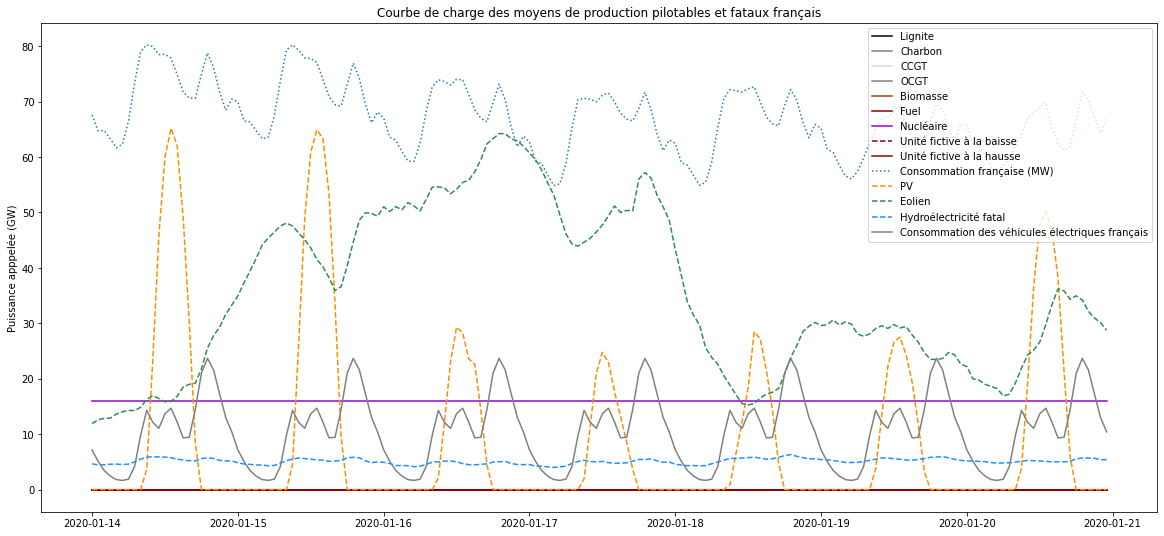

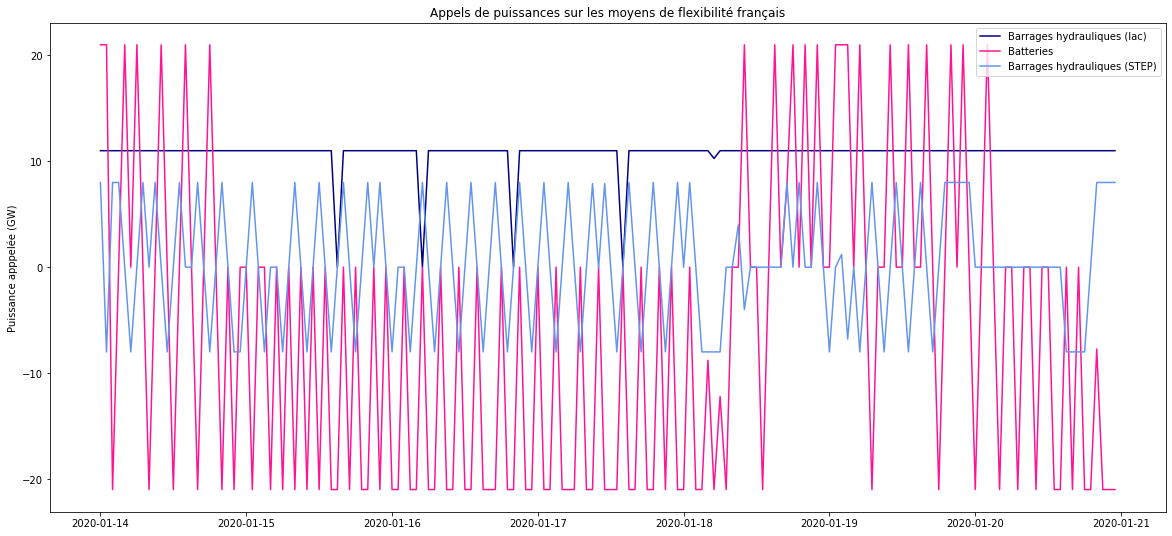

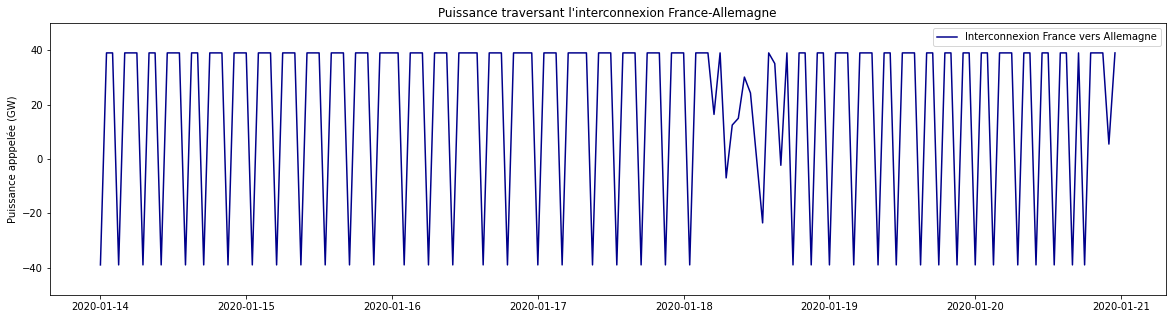

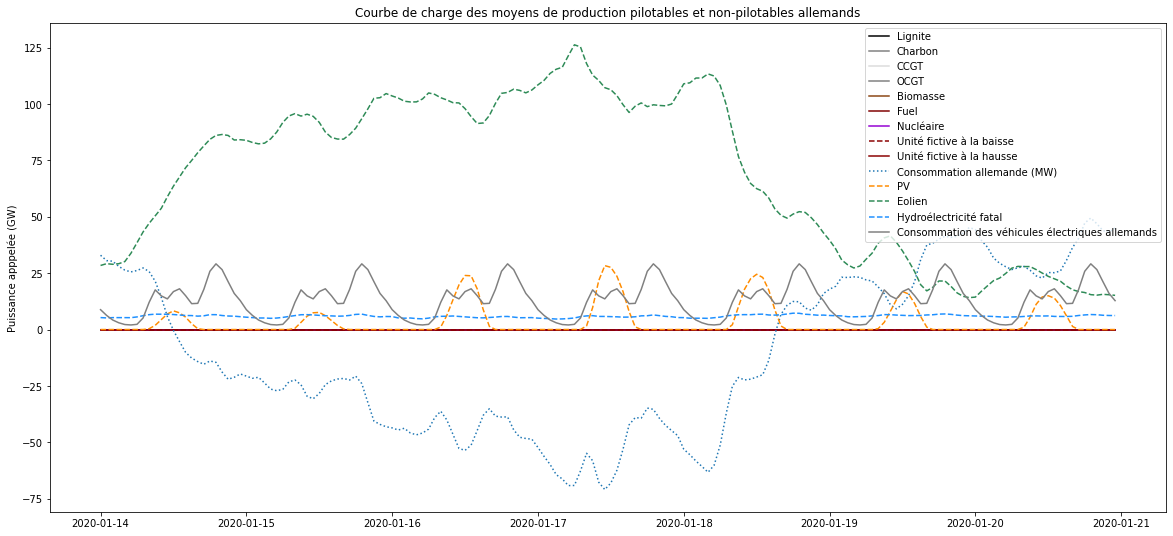

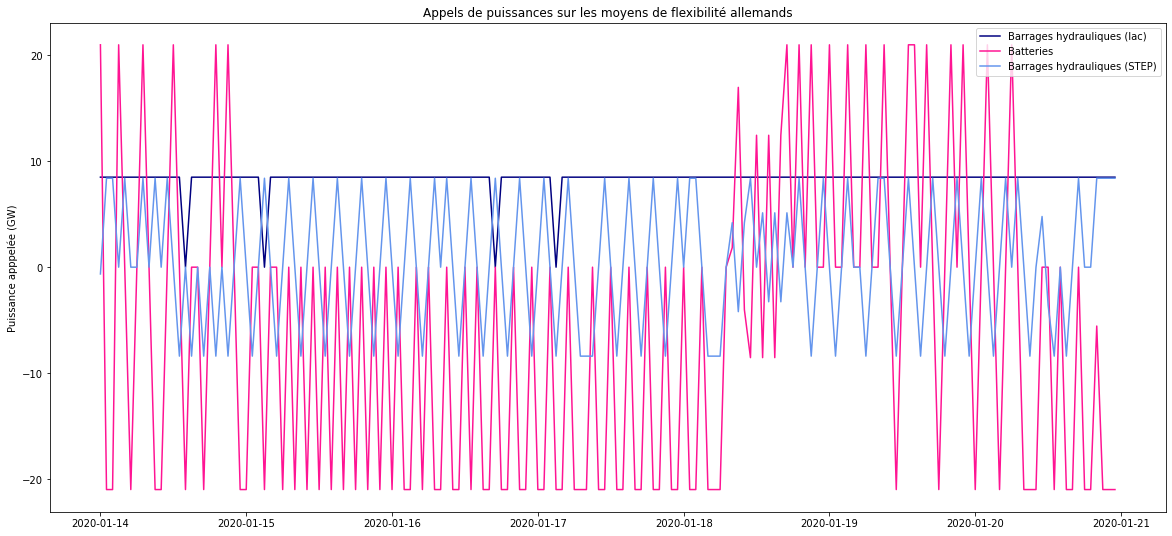

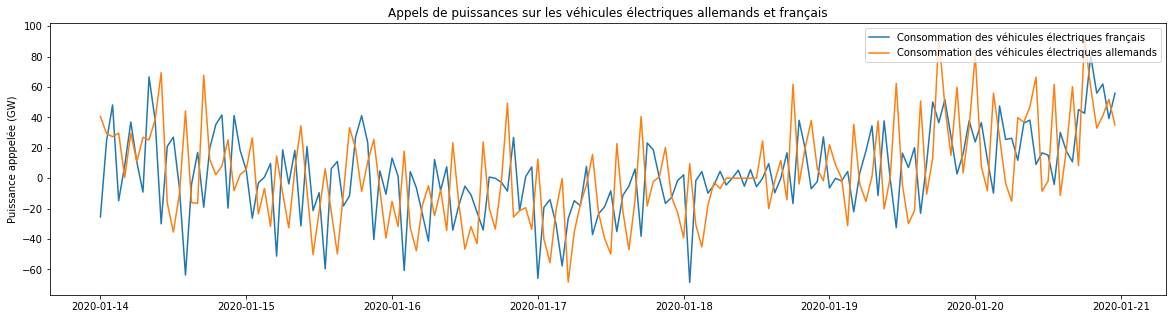

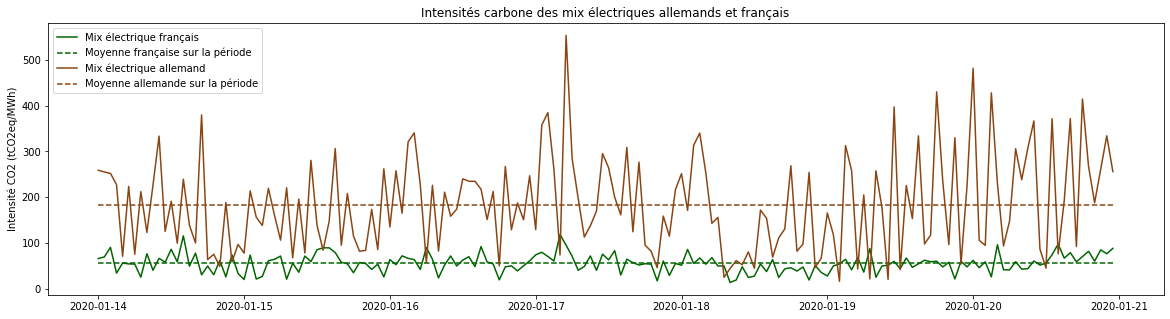

In [111]:
sol = solver(scenario_demand='sobr',scenario_ev='ref',scenario_prod_fr='M1',scenario_prod_all='ev')